## Workflow Overview

### 1. Importing Libraries
Import all required libraries for data handling, visualization, and text analysis.

---

### 2. Reading and Transforming Both Datasets
- Load both research paper and hospital datasets.
- Modified the columns of Research Paper data to get only 4 final columns ‘ID’, ‘OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS'
- For the hospital dataset, combine all columns (except `Age Group` and `Gender`) into a single text column named `Medical_Information`.
- Use only the first 50,000 rows for analysis.

---

### 3. EDA on Raw Data

- Plot 1: Most Frequent Terms in Research Papers  
- Plot 2: Papers Containing Mathematical Terms / Formulas / Equations by Section

---

### 4. Data Cleaning

- Step 1: Remove URLs  
- Step 2: Remove mathematical equations and formulas (digits and math symbols)  
- Step 3: Remove lone characters like `'n'`  
- Step 4: Remove extra spaces, newlines, and tabs  
- Step 5: Convert all text to lowercase  
- Step 6: Remove stopwords  
- Step 7: Remove punctuations

---

### 5. Pattern Discovery and Visualization on Cleaned Data

#### Univariate Analysis

- Plot 3: Top 20 Dominant Research Goals Identified from Study Objectives  
- Plot 4: How Do Medical Papers Conclude?  
  Sentiment Distribution (Pretrained Classification Patterns using VADER)  
- Plot 5: How Diverse Are Medical Methods?  
  A Cluster View using KMeans on `METHODS` section  
- Plot 6: Top Unigrams & Bigrams by Section  
  A Linguistic Snapshot

---

#### Bivariate Analysis

- Plot 7: Readability vs Length of Full Papers  
  Using Flesch Reading Ease Score (higher = easier)

---

#### Multivariate Analysis

- Plot 8: Section-wise Linguistic Analysis of Medical Papers  
  Compares:  
  - Vocabulary Richness  
  - Flesch Reading Ease  
  - Gunning Fog Index
- Plot 9:Structural Coherence Across Research (TF-IDF Cosine Semantic Pattern Alignment)

## 1. Importing Libraries

In [98]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import random
import re
import string
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from langdetect import detect, DetectorFactory
import langcodes
import textstat
from textstat import flesch_reading_ease, gunning_fog
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans



[nltk_data] Downloading package punkt to C:\Users\Sakshi
[nltk_data]     Vishwakarma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Reading and transforming both the datasets

In [64]:
def parse_research_abstracts(file_path):
    
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
   
    abstracts = re.split(r'###(\d+)', content)

    if abstracts[0].strip() == '':
        abstracts = abstracts[1:]
    data = []

    for i in range(0, len(abstracts), 2):
        if i + 1 < len(abstracts):
            research_id = abstracts[i].strip()
            abstract_text = abstracts[i + 1].strip()
            sections = defaultdict(list)
            lines = abstract_text.split('\n')
            current_section = None
            
            for line in lines:
                line = line.strip()
                if not line:
                    continue
                
                section_match = re.match(r'^(BACKGROUND|OBJECTIVE|METHODS?|RESULTS?|CONCLUSIONS?)\s+(.+)', line)
                if section_match:
                    current_section = section_match.group(1)
                    # Normalizing section names
                    if current_section in ['METHOD', 'METHODS']:
                        current_section = 'METHODS'
                    elif current_section in ['RESULT', 'RESULTS']:
                        current_section = 'RESULTS'
                    elif current_section in ['CONCLUSION', 'CONCLUSIONS']:
                        current_section = 'CONCLUSIONS'
                    
                    sections[current_section].append(section_match.group(2))
                elif current_section:
                    sections[current_section].append(line)
            
            row_data = {'ID': research_id}
            for section, texts in sections.items():
                row_data[section] = ' '.join(texts)
            
            # Ensuring all possible columns exist (fill with empty string if missing)
            for col in ['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS']:
                if col not in row_data:
                    row_data[col] = ''
            
            data.append(row_data)

    df = pd.DataFrame(data)
    
    # Reordering columns
    column_order = ['ID', 'BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS']
    df = df.reindex(columns=column_order)
    return df

if __name__ == "__main__":
    df = parse_research_abstracts('C://Users//Sakshi Vishwakarma//Downloads//data//train.txt')
    df = df.sample(n=20000, random_state=42)

In [65]:
df['OBJECTIVE_BACKGROUND'] = (df['OBJECTIVE'].fillna('') + ' ' + df['BACKGROUND'].fillna('')).str.strip()
df['RESULTS_CONCLUSIONS'] = (df['RESULTS'].fillna('') + ' ' + df['CONCLUSIONS'].fillna('')).str.strip()
df = df[['ID', 'OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']]

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 181312 to 43075
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20000 non-null  object
 1   OBJECTIVE_BACKGROUND  20000 non-null  object
 2   METHODS               20000 non-null  object
 3   RESULTS_CONCLUSIONS   20000 non-null  object
dtypes: object(4)
memory usage: 781.2+ KB


In [67]:
df.tail()

,ID,OBJECTIVE_BACKGROUND,METHODS,RESULTS_CONCLUSIONS
162178,11113831,To elaborate and validate a Preschool Respirat...,A prospective cohort study was performed in 21...,"For the test group ( N = 145 ) , the best mult..."
74873,23915267,To evaluate the effectiveness of a new multifa...,Experimental study . Randomized clinical trial...,This study aims to evaluate the efficacy of a ...
151086,19243778,We tested the effect of an education and couns...,We conducted a two-group randomized controlled...,"Knowledge , attitudes and beliefs scores incre..."
109269,15825733,To determine and compare levels of sedation ac...,Prospective randomized study . 56 dogs . Dogs ...,Dogs in the acepromazine group had significant...
43075,17313003,To observe the analgesic effect of ankle-three...,Three hundred and eighty cases were randomly d...,The time inducing analgesia was 6 min in the a...


In [68]:
df.shape

(20000, 4)

In [99]:
file_path = 'C://Users//Sakshi Vishwakarma//Downloads//data//hospital-inpatient-discharges.xlsx'
data2 = pd.read_excel(file_path)

data2 = data2.head(50000)
cols_to_combine = [col for col in data2.columns if col not in ['Age Group', 'Gender']]
data2['Medical_Information'] = data2[cols_to_combine].astype(str).agg(' '.join, axis=1)
data2 = data2[['Age Group', 'Gender', 'Medical_Information']]

data2.head()

,Age Group,Gender,Medical_Information
0,18 to 29,F,0 White Not Span/Hispanic 1 Emergency INTESTIN...
1,50 to 69,M,1 White Not Span/Hispanic 15 Emergency OTHER F...
2,70 or Older,M,2 White Not Span/Hispanic 3 Emergency SECONDAR...
3,70 or Older,F,3 White Not Span/Hispanic 5 Elective REHAB/PRO...
4,70 or Older,F,4 White Not Span/Hispanic 4 Elective OSTEOARTH...


## 3. EDA on Raw Data

In [69]:
sections = ['OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']

# Calculating word and sentence counts
for col in sections:
    df[col + '_wc'] = df[col].apply(lambda x: len(str(x).split()))
    df[col + '_sc'] = df[col].apply(lambda x: len(sent_tokenize(str(x))))

df[[col + '_wc' for col in sections] + [col + '_sc' for col in sections]].describe().round(2)


,OBJECTIVE_BACKGROUND_wc,METHODS_wc,RESULTS_CONCLUSIONS_wc,OBJECTIVE_BACKGROUND_sc,METHODS_sc,RESULTS_CONCLUSIONS_sc
count,20000.00,20000.00,20000.00,20000.00,20000.00,20000.00
mean,50.21,93.92,160.24,2.03,3.84,5.86
std,27.76,46.28,67.70,1.21,2.09,2.31
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,29.00,65.00,115.00,1.00,2.00,4.00
50%,45.00,89.00,152.00,2.00,4.00,6.00
75%,64.00,118.00,196.00,3.00,5.00,7.00
max,349.00,1036.00,816.00,12.00,30.00,29.00


### Plot-1 : Most Frequent Terms in Research Papers

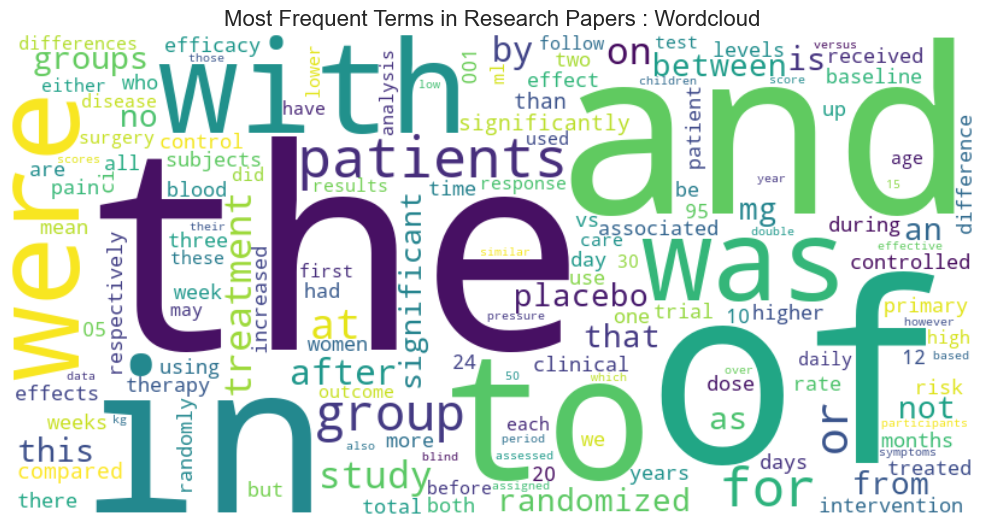

In [70]:
# Combine all sections into one long text series
sections = ['OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']
combined_texts = df[sections].fillna('').agg(' '.join, axis=1)

def get_top_ngrams(texts, ngram_range=(1,1), top_n=100):
    vec = CountVectorizer(ngram_range=ngram_range)
    bag = vec.fit_transform(texts)
    sum_words = bag.sum(axis=0)
    words_freq = {word: sum_words[0, idx] for word, idx in vec.vocabulary_.items()}
    sorted_words = dict(sorted(words_freq.items(), key=lambda item: item[1], reverse=True)[:top_n])
    return sorted_words

top_unigrams = get_top_ngrams(combined_texts, ngram_range=(1,1), top_n=150)

wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(top_unigrams)

plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Terms in Research Papers : Wordcloud', fontsize=16)
plt.tight_layout()
plt.show()


### Plot-2 : Papers Containing Mathematical terms / Formulas / Equations by Section 

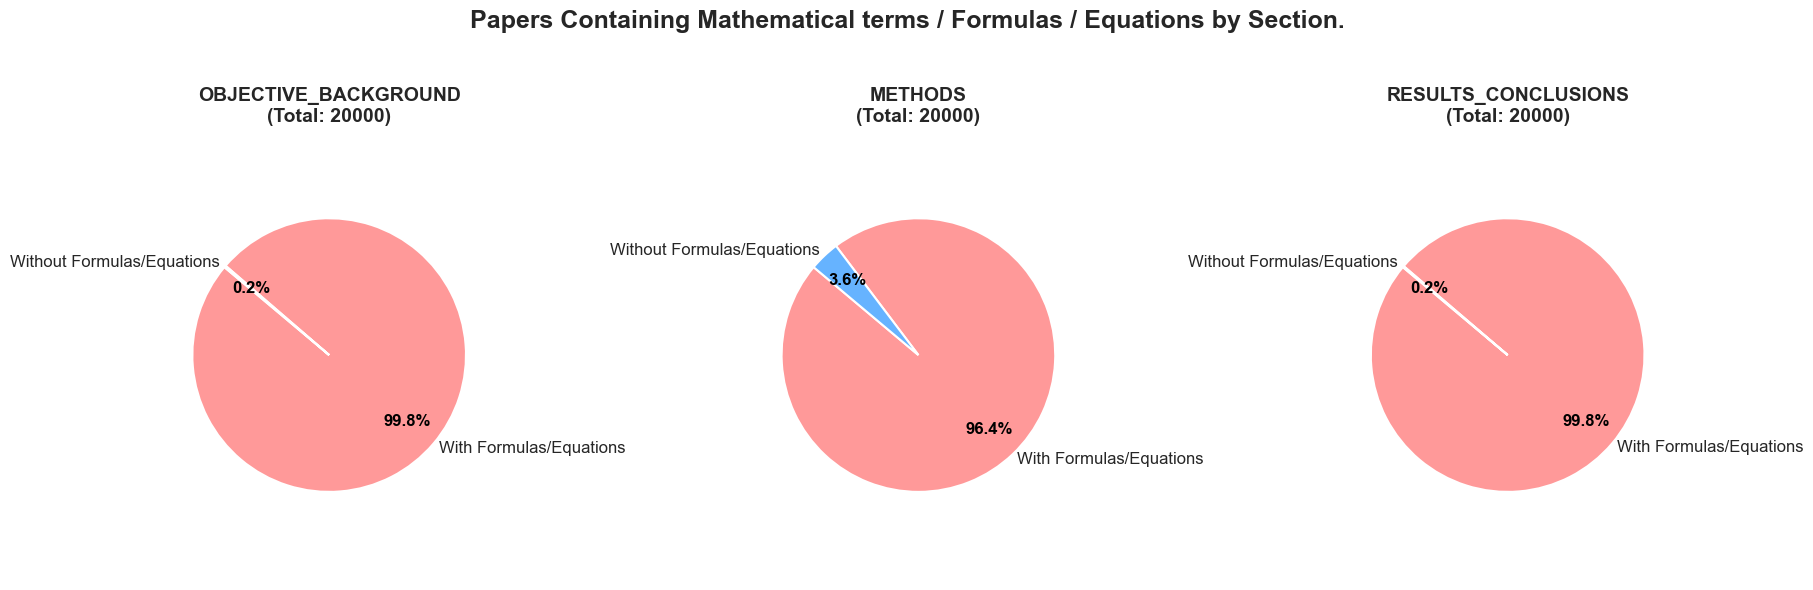

In [71]:
math_pattern = re.compile(r'[\d\.\,\+\-\*\/\=\>\<\%\(\)]+')

sections = ['OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']
total_entries = len(df)

fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
colors = ['#ff9999', '#66b3ff']

for i, section in enumerate(sections):
    math_count = df[section].apply(lambda x: bool(math_pattern.search(str(x)))).sum()
    no_math_count = total_entries - math_count
    
    sizes = [math_count, no_math_count]
    labels = ['With Formulas/Equations', 'Without Formulas/Equations']
    
    wedges, texts, autotexts = axes[i].pie(
        sizes, labels=labels, autopct='%1.1f%%', startangle=140,
        colors=colors, textprops={'fontsize': 12},
        pctdistance=0.75, labeldistance=1.05,
        wedgeprops={'edgecolor': 'w', 'linewidth': 1.5})
  
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
    
    axes[i].set_title(f"{section}\n(Total: {total_entries})", fontsize=14, fontweight='bold')
    axes[i].axis('equal')  

plt.suptitle('Papers Containing Mathematical terms / Formulas / Equations by Section.', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [72]:
df = df[['ID', 'OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']]

## 4. Data Cleaning

### Step-1 : Removing URLs

In [73]:
url_pattern = re.compile(r'((https?|ftp):\/\/\S+)|(www\.\S+)|(\b\w+\.(com|org|net|edu|gov|io|ai|in|uk|co)\b)', re.IGNORECASE)

for section in sections:
    df[section] = df[section].apply(lambda x: url_pattern.sub('', str(x)))

df.head()

,ID,OBJECTIVE_BACKGROUND,METHODS,RESULTS_CONCLUSIONS
181312,15002887,Tobacco smoking is an established risk factor ...,Sixty smokers ( aged 35-59 years ; 23 females ...,Subjects using the triclosan/copolymer/fluorid...
128734,14652118,To evaluate the efficacy and safety of propofo...,"Randomized , double-blinded , placebo-controll...",The percentage of patients who were emesis-fre...
58248,17868127,This article reports lifetime Axis I and II co...,"Outpatient AN ( n = 56 ) , BN ( n = 132 ) , an...","In the AN sample as a whole , specific elevati..."
31064,22457014,Leukotriene D ( 4 ) ( LTD ( 4 ) ) is a central...,"Treatments were evaluated in a randomized , th...","Compared with placebo , salbutamol provided si..."
34665,18475165,Individual blood pressure responses to antihyp...,"In the GENRES study , 208 Finnish men aged 35-...",Serum total calcium concentration was negative...


In [74]:
df['METHODS'][181312]

'Sixty smokers ( aged 35-59 years ; 23 females ) with chronic periodontal disease volunteered to participate in a double-blind , randomized , controlled , clinical trial . The subjects were randomly assigned to use a triclosan/copolymer/fluoride ( 30 subjects ) or a standard fluoride ( 30 subjects ) dentifrice and received detailed information on proper techniques for self-performed plaque control . The participants then received non-surgical periodontal therapy followed by periodontal maintenance care every 6 months over 24 months . Clinical recordings included evaluation of oral hygiene standards , gingival health , and periodontal status .'

### Step-2 : Removing mathematical equations and formulas (digits and math symbols)

In [75]:
math_pattern = re.compile(r'[\d\.\,\+\-\*\/\=\>\<\%\(\)\[\]\{\}]+')

for section in sections:
    df[section] = df[section].apply(lambda x: math_pattern.sub('', str(x)))
df.head()

,ID,OBJECTIVE_BACKGROUND,METHODS,RESULTS_CONCLUSIONS
181312,15002887,Tobacco smoking is an established risk factor ...,Sixty smokers aged years ; females with ch...,Subjects using the triclosancopolymerfluoride ...
128734,14652118,To evaluate the efficacy and safety of propofo...,Randomized doubleblinded placebocontrolled s...,The percentage of patients who were emesisfree...
58248,17868127,This article reports lifetime Axis I and II co...,Outpatient AN n BN n and DEP n s...,In the AN sample as a whole specific elevatio...
31064,22457014,Leukotriene D LTD is a central mediato...,Treatments were evaluated in a randomized thr...,Compared with placebo salbutamol provided sig...
34665,18475165,Individual blood pressure responses to antihyp...,In the GENRES study Finnish men aged years ...,Serum total calcium concentration was negative...


In [76]:
df['METHODS'][181312]

'Sixty smokers  aged  years ;  females  with chronic periodontal disease volunteered to participate in a doubleblind  randomized  controlled  clinical trial  The subjects were randomly assigned to use a triclosancopolymerfluoride   subjects  or a standard fluoride   subjects  dentifrice and received detailed information on proper techniques for selfperformed plaque control  The participants then received nonsurgical periodontal therapy followed by periodontal maintenance care every  months over  months  Clinical recordings included evaluation of oral hygiene standards  gingival health  and periodontal status '

### Step-3 : Removing lone characters like 'n'


In [77]:
lone_char_pattern = re.compile(r'\b[n]\b', re.IGNORECASE)

for section in sections:
    df[section] = df[section].apply(lambda x: lone_char_pattern.sub('', str(x)))
df.head()

,ID,OBJECTIVE_BACKGROUND,METHODS,RESULTS_CONCLUSIONS
181312,15002887,Tobacco smoking is an established risk factor ...,Sixty smokers aged years ; females with ch...,Subjects using the triclosancopolymerfluoride ...
128734,14652118,To evaluate the efficacy and safety of propofo...,Randomized doubleblinded placebocontrolled s...,The percentage of patients who were emesisfree...
58248,17868127,This article reports lifetime Axis I and II co...,Outpatient AN BN and DEP samp...,In the AN sample as a whole specific elevatio...
31064,22457014,Leukotriene D LTD is a central mediato...,Treatments were evaluated in a randomized thr...,Compared with placebo salbutamol provided sig...
34665,18475165,Individual blood pressure responses to antihyp...,In the GENRES study Finnish men aged years ...,Serum total calcium concentration was negative...


In [78]:
df['METHODS'][181312]

'Sixty smokers  aged  years ;  females  with chronic periodontal disease volunteered to participate in a doubleblind  randomized  controlled  clinical trial  The subjects were randomly assigned to use a triclosancopolymerfluoride   subjects  or a standard fluoride   subjects  dentifrice and received detailed information on proper techniques for selfperformed plaque control  The participants then received nonsurgical periodontal therapy followed by periodontal maintenance care every  months over  months  Clinical recordings included evaluation of oral hygiene standards  gingival health  and periodontal status '

### Step-4 : Removing extra spaces, newlines, tabs

In [79]:
for section in sections:
    df[section] = df[section].apply(lambda x: re.sub(r'\s+', ' ', str(x)).strip())
df.head()

,ID,OBJECTIVE_BACKGROUND,METHODS,RESULTS_CONCLUSIONS
181312,15002887,Tobacco smoking is an established risk factor ...,Sixty smokers aged years ; females with chroni...,Subjects using the triclosancopolymerfluoride ...
128734,14652118,To evaluate the efficacy and safety of propofo...,Randomized doubleblinded placebocontrolled stu...,The percentage of patients who were emesisfree...
58248,17868127,This article reports lifetime Axis I and II co...,Outpatient AN BN and DEP samples were assessed...,In the AN sample as a whole specific elevation...
31064,22457014,Leukotriene D LTD is a central mediator in ast...,Treatments were evaluated in a randomized thre...,Compared with placebo salbutamol provided sign...
34665,18475165,Individual blood pressure responses to antihyp...,In the GENRES study Finnish men aged years wit...,Serum total calcium concentration was negative...


In [80]:
df['METHODS'][181312]

'Sixty smokers aged years ; females with chronic periodontal disease volunteered to participate in a doubleblind randomized controlled clinical trial The subjects were randomly assigned to use a triclosancopolymerfluoride subjects or a standard fluoride subjects dentifrice and received detailed information on proper techniques for selfperformed plaque control The participants then received nonsurgical periodontal therapy followed by periodontal maintenance care every months over months Clinical recordings included evaluation of oral hygiene standards gingival health and periodontal status'

### Step-5 : Lowercasing all the text

In [81]:
for section in sections:
    df[section] = df[section].apply(lambda x: str(x).lower())
df.head()

,ID,OBJECTIVE_BACKGROUND,METHODS,RESULTS_CONCLUSIONS
181312,15002887,tobacco smoking is an established risk factor ...,sixty smokers aged years ; females with chroni...,subjects using the triclosancopolymerfluoride ...
128734,14652118,to evaluate the efficacy and safety of propofo...,randomized doubleblinded placebocontrolled stu...,the percentage of patients who were emesisfree...
58248,17868127,this article reports lifetime axis i and ii co...,outpatient an bn and dep samples were assessed...,in the an sample as a whole specific elevation...
31064,22457014,leukotriene d ltd is a central mediator in ast...,treatments were evaluated in a randomized thre...,compared with placebo salbutamol provided sign...
34665,18475165,individual blood pressure responses to antihyp...,in the genres study finnish men aged years wit...,serum total calcium concentration was negative...


In [82]:
df['METHODS'][181312]

'sixty smokers aged years ; females with chronic periodontal disease volunteered to participate in a doubleblind randomized controlled clinical trial the subjects were randomly assigned to use a triclosancopolymerfluoride subjects or a standard fluoride subjects dentifrice and received detailed information on proper techniques for selfperformed plaque control the participants then received nonsurgical periodontal therapy followed by periodontal maintenance care every months over months clinical recordings included evaluation of oral hygiene standards gingival health and periodontal status'

### Step-6 : Removing stopwords

In [83]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = str(text).split()
    filtered = [w for w in words if w not in stop_words]
    return ' '.join(filtered)

for section in sections:
    df[section] = df[section].apply(remove_stopwords)
df.head()

,ID,OBJECTIVE_BACKGROUND,METHODS,RESULTS_CONCLUSIONS
181312,15002887,tobacco smoking established risk factor period...,sixty smokers aged years ; females chronic per...,subjects using triclosancopolymerfluoride dent...
128734,14652118,evaluate efficacy safety propofol subhypnotic ...,randomized doubleblinded placebocontrolled stu...,percentage patients emesisfree defined experie...
58248,17868127,article reports lifetime axis ii comorbidity w...,outpatient bn dep samples assessed using struc...,sample whole specific elevations found prevale...
31064,22457014,leukotriene ltd central mediator asthma induci...,treatments evaluated randomized threeperiod do...,compared placebo salbutamol provided significa...
34665,18475165,individual blood pressure responses antihypert...,genres study finnish men aged years moderate h...,serum total calcium concentration negatively c...


In [84]:
df['METHODS'][181312]

'sixty smokers aged years ; females chronic periodontal disease volunteered participate doubleblind randomized controlled clinical trial subjects randomly assigned use triclosancopolymerfluoride subjects standard fluoride subjects dentifrice received detailed information proper techniques selfperformed plaque control participants received nonsurgical periodontal therapy followed periodontal maintenance care every months months clinical recordings included evaluation oral hygiene standards gingival health periodontal status'

### Step-7 : Removing Punctuations

In [85]:
punctuation_pattern = re.compile(f"[{re.escape(string.punctuation)}]")

for section in sections:
    df[section] = df[section].apply(lambda x: punctuation_pattern.sub('', str(x)))
df.head()

,ID,OBJECTIVE_BACKGROUND,METHODS,RESULTS_CONCLUSIONS
181312,15002887,tobacco smoking established risk factor period...,sixty smokers aged years females chronic peri...,subjects using triclosancopolymerfluoride dent...
128734,14652118,evaluate efficacy safety propofol subhypnotic ...,randomized doubleblinded placebocontrolled stu...,percentage patients emesisfree defined experie...
58248,17868127,article reports lifetime axis ii comorbidity w...,outpatient bn dep samples assessed using struc...,sample whole specific elevations found prevale...
31064,22457014,leukotriene ltd central mediator asthma induci...,treatments evaluated randomized threeperiod do...,compared placebo salbutamol provided significa...
34665,18475165,individual blood pressure responses antihypert...,genres study finnish men aged years moderate h...,serum total calcium concentration negatively c...


In [86]:
df['METHODS'][181312]

'sixty smokers aged years  females chronic periodontal disease volunteered participate doubleblind randomized controlled clinical trial subjects randomly assigned use triclosancopolymerfluoride subjects standard fluoride subjects dentifrice received detailed information proper techniques selfperformed plaque control participants received nonsurgical periodontal therapy followed periodontal maintenance care every months months clinical recordings included evaluation oral hygiene standards gingival health periodontal status'

## 5. Pattern Discovery and Visualization on Cleaned Data

## Univariate Analysis

### PLOT-3: Top 20 Dominant Research Goals Identified from Study Objectives 

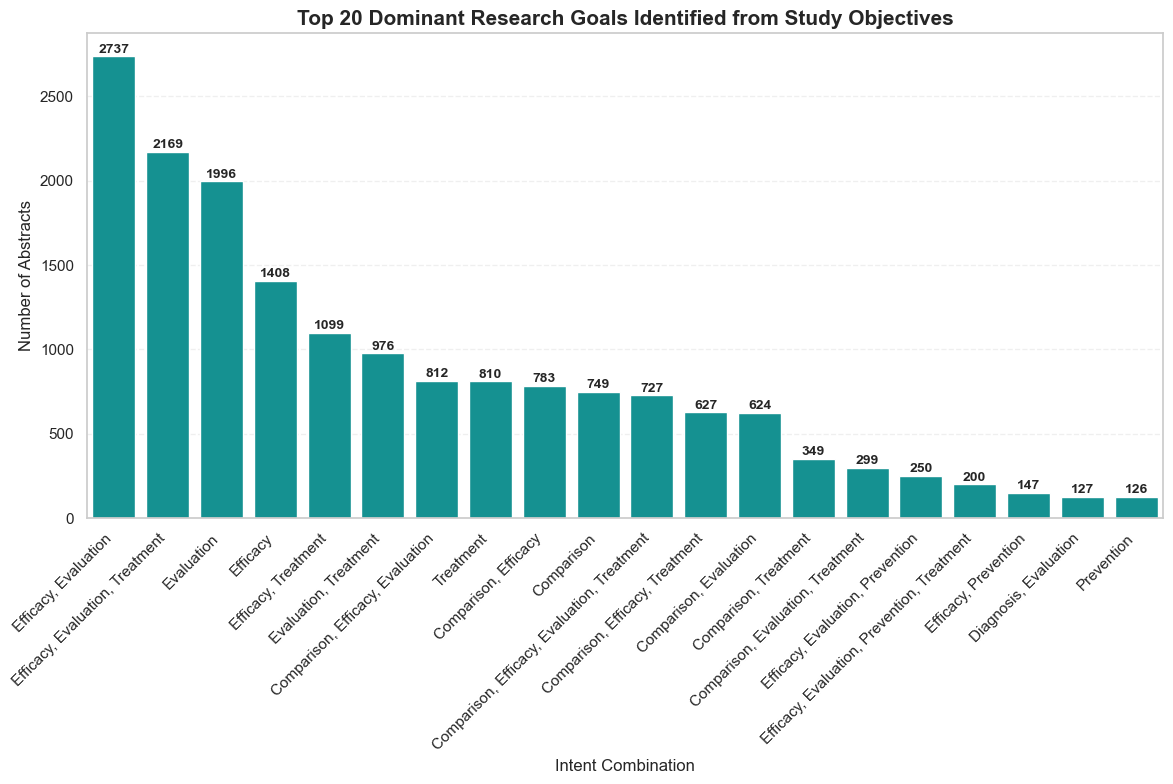

In [88]:
intent_keywords = {
    'Treatment': ['treat', 'therapy', 'therapeutic', 'intervention', 'treatment'],
    'Prevention': ['prevent', 'prevention', 'prophylaxis', 'reduce risk', 'protective'],
    'Diagnosis': ['diagnose', 'diagnostic', 'detect', 'identification', 'screening'],
    'Comparison': ['compare', 'versus', 'vs', 'comparison', 'comparative'],
    'Evaluation': ['evaluate', 'assessment', 'examine', 'investigate', 'study'],
    'Efficacy': ['efficacy', 'effectiveness', 'effect', 'outcome', 'benefit']}


def extract_intents(text):
    matched_intents = []
    text = str(text).lower()
    for intent, keywords in intent_keywords.items():
        if any(keyword in text for keyword in keywords):
            matched_intents.append(intent)
    return matched_intents

df['research_intents'] = df['OBJECTIVE_BACKGROUND'].apply(extract_intents)
df['intent_combo'] = df['research_intents'].apply(lambda x: ', '.join(sorted(x)))
df_filtered = df[df['intent_combo'] != '']


combo_counts = df_filtered['intent_combo'].value_counts().sort_values(ascending=False)
top_n = 20

plt.figure(figsize=(12, 8))
bar_color = '#00A6A6' 

sns.barplot( x=combo_counts[:top_n].index, y=combo_counts[:top_n].values, color=bar_color)
for i, count in enumerate(combo_counts[:top_n].values):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title(f'Top 20 Dominant Research Goals Identified from Study Objectives', fontsize=15, fontweight='bold')
plt.ylabel('Number of Abstracts', fontsize=12)
plt.xlabel('Intent Combination', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### PLOT-4: How Do Medical Papers Conclude? Sentiment Distribution (Pretrained Classification Patterns analysis with VADER)

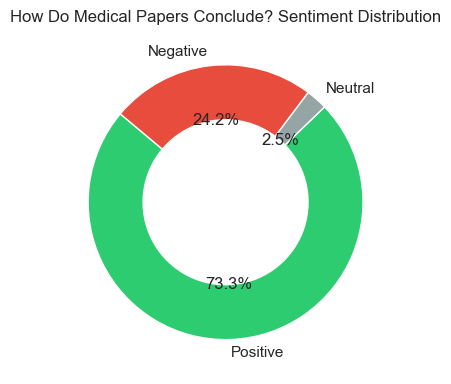

In [89]:
analyzer = SentimentIntensityAnalyzer()

def classify_sentiment(text):
    if pd.isna(text) or not isinstance(text, str) or text.strip() == "":
        return "Neutral"
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df['vader_class'] = df['RESULTS_CONCLUSIONS'].astype(str).apply(classify_sentiment)
sentiment_counts = df['vader_class'].value_counts().reindex(['Positive', 'Neutral', 'Negative'])

plt.figure(figsize=(4, 4))
colors = ['#2ecc71', '#95a5a6', '#e74c3c']  # green, grey, red
plt.pie(sentiment_counts, labels=sentiment_counts.index, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.4})
plt.title('How Do Medical Papers Conclude? Sentiment Distribution')
plt.tight_layout()
plt.show()


### PLOT-5: How Diverse Are Medical Methods? A Cluster View 

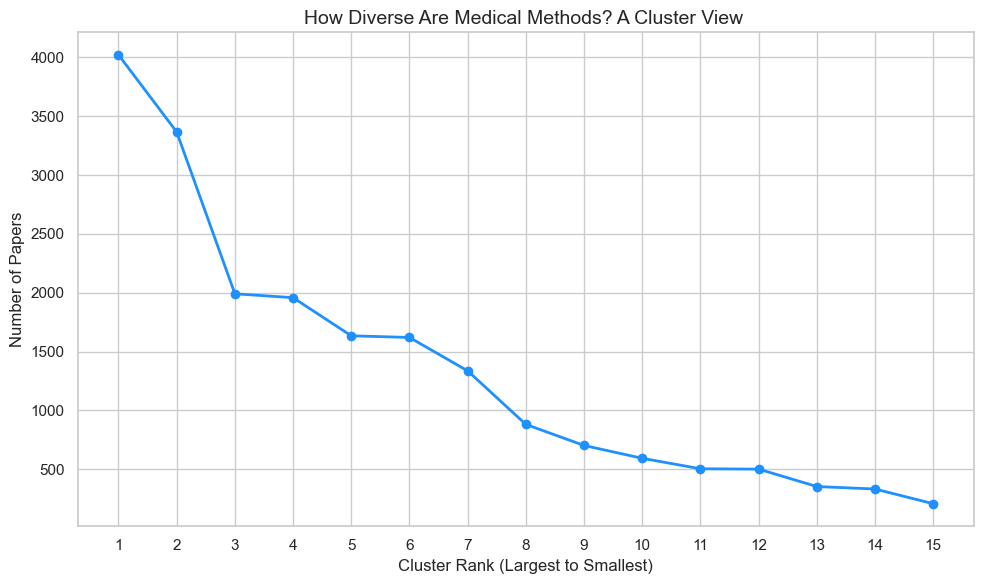

In [91]:
texts = df['METHODS'].fillna('').astype(str).tolist()
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(texts)
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(X)
unique, counts = np.unique(clusters, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
sorted_sizes = sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)


plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
plt.plot(range(1, len(sorted_sizes) + 1), [size[1] for size in sorted_sizes],marker='o', linestyle='-', color='dodgerblue', linewidth=2)
plt.title('How Diverse Are Medical Methods? A Cluster View ', fontsize=14)
plt.xlabel('Cluster Rank (Largest to Smallest)', fontsize=12)
plt.ylabel('Number of Papers', fontsize=12)
plt.xticks(range(1, len(sorted_sizes) + 1))
plt.grid(True)
plt.tight_layout()
plt.show()


### PLOT-6: Top Unigrams & Bigrams by Section: A Linguistic Snapshot

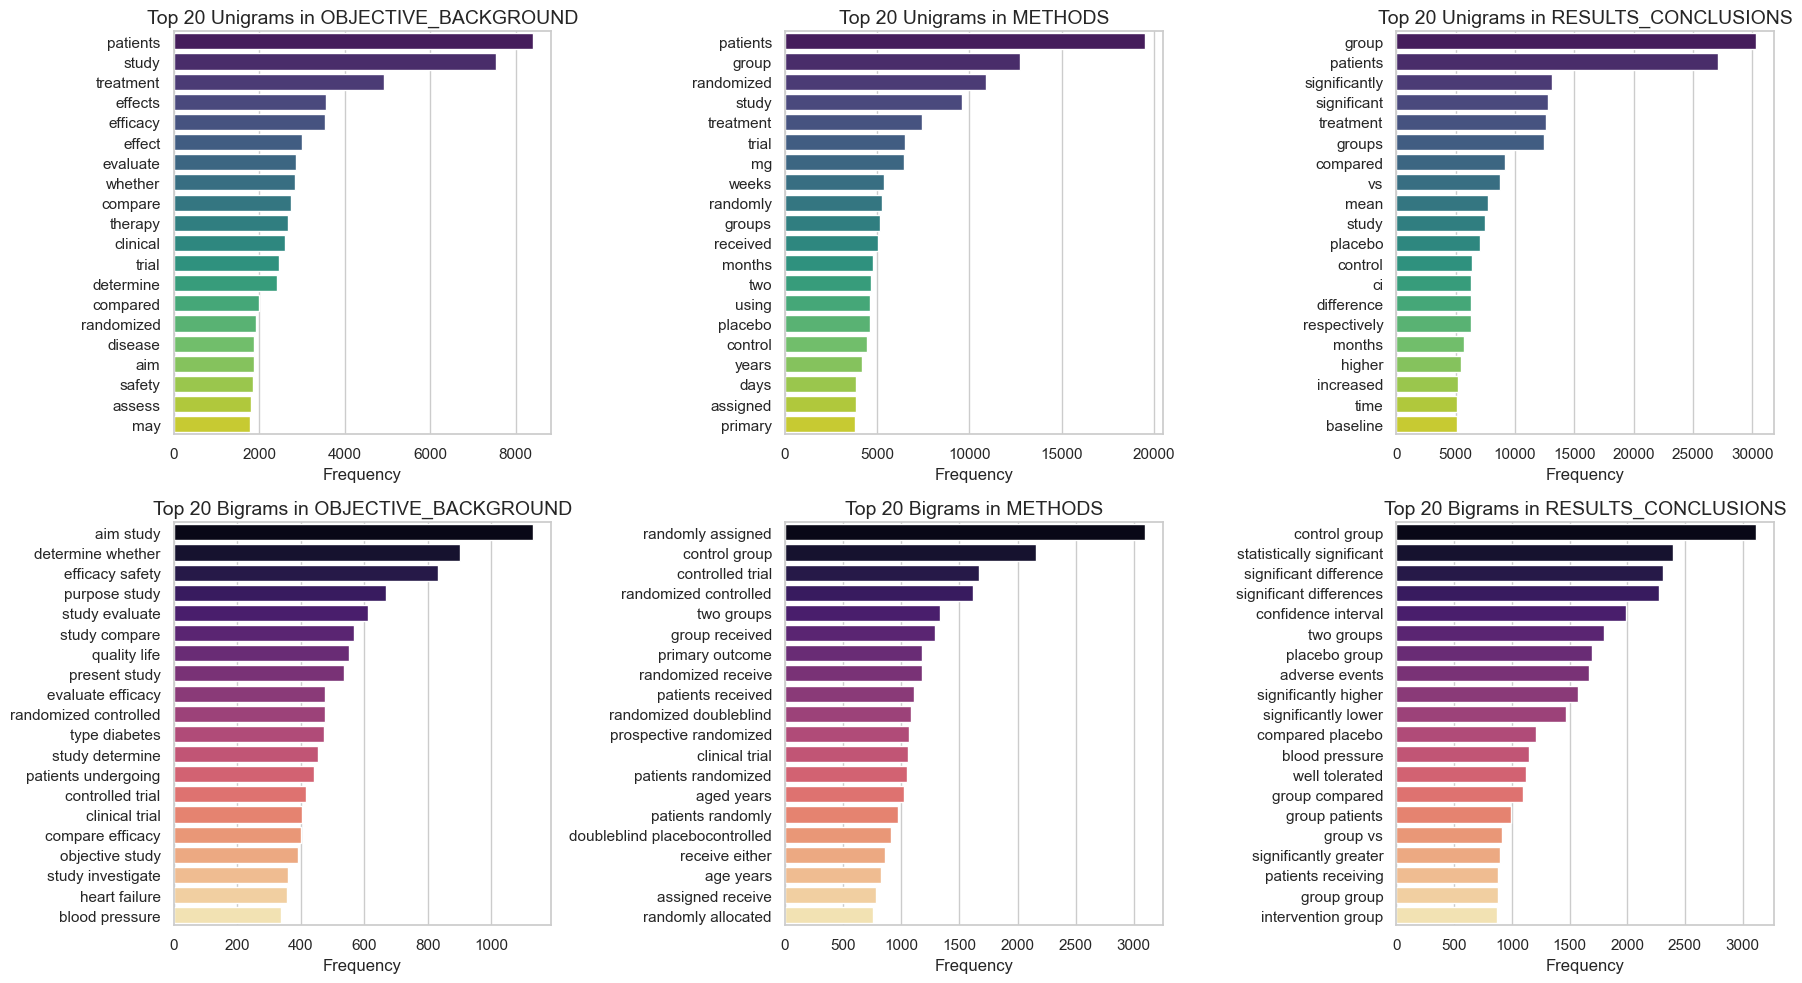

In [87]:
def get_top_ngrams(texts, ngram_range=(1,1), top_n=10):
    vec = CountVectorizer(ngram_range=ngram_range)  
    bag = vec.fit_transform(texts.dropna().astype(str))
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]
    return zip(*words_freq) 

sections = ['OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)  

for col_idx, section in enumerate(sections):
    # Unigrams
    words, freqs = get_top_ngrams(df[section], ngram_range=(1,1), top_n=20)
    sns.barplot(x=list(freqs), y=list(words), ax=axes[0, col_idx], palette='viridis')
    axes[0, col_idx].set_title(f"Top 20 Unigrams in {section}", fontsize=14)
    axes[0, col_idx].set_xlabel('Frequency', fontsize=12)
    axes[0, col_idx].set_ylabel('')
    axes[0, col_idx].tick_params(axis='y', labelsize=11)
    
    # Bigrams
    words, freqs = get_top_ngrams(df[section], ngram_range=(2,2), top_n=20)
    sns.barplot(x=list(freqs), y=list(words), ax=axes[1, col_idx], palette='magma')
    axes[1, col_idx].set_title(f"Top 20 Bigrams in {section}", fontsize=14)
    axes[1, col_idx].set_xlabel('Frequency', fontsize=12)
    axes[1, col_idx].set_ylabel('')
    axes[1, col_idx].tick_params(axis='y', labelsize=11)

plt.tight_layout()
plt.show()


## Bivariate Analysis

### PLOT-7: Readability vs Length of Full Papers (using Flesch Reading Ease Score (higher = easier)) 

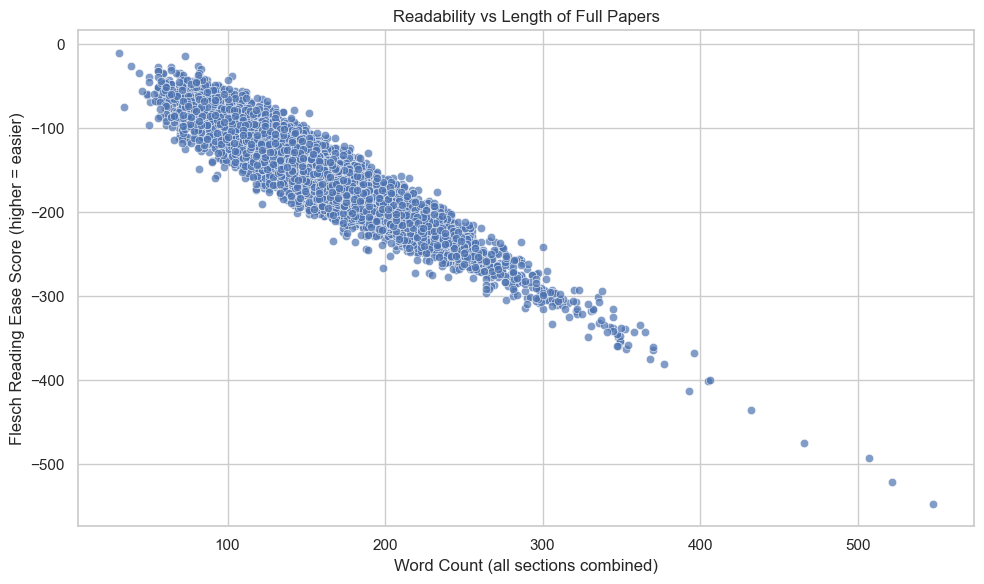

In [95]:
sections = ['OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS'] 

df['combined_text'] = df[sections].fillna('').agg(' '.join, axis=1)
df['combined_wordcount'] = df['combined_text'].apply(lambda x: len(x.split()))
df['combined_flesch'] = df['combined_text'].apply(lambda x: textstat.flesch_reading_ease(x))

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='combined_wordcount', y='combined_flesch', alpha=0.7)

plt.title('Readability vs Length of Full Papers')
plt.xlabel('Word Count (all sections combined)')
plt.ylabel('Flesch Reading Ease Score (higher = easier)')
plt.grid(True)
plt.tight_layout()
plt.show()


### PLOT-8: Section-wise Linguistic Analysis of Medical Papers  

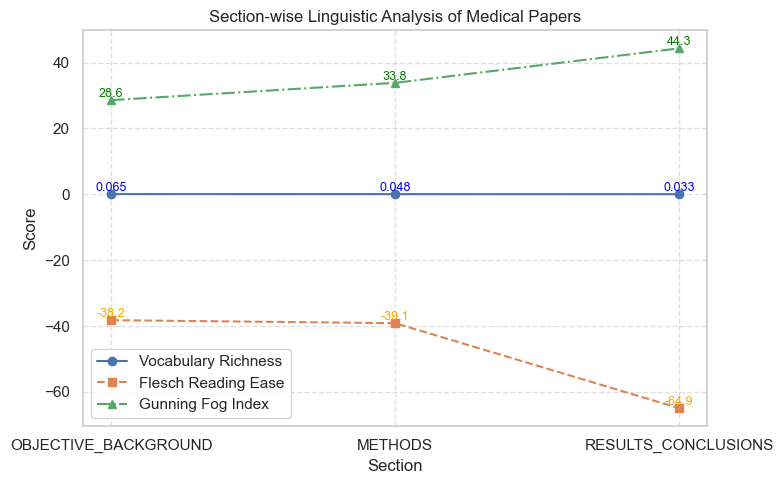

In [96]:
sections = ['OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']
metrics = ['Vocabulary Richness', 'Flesch Reading Ease', 'Gunning Fog Index']

vocab_richness = []
flesch_means = []
fog_means = []

for section in sections:
    texts = df[section].dropna().astype(str)
    total_words = texts.str.split().apply(len).sum()
    all_words = " ".join(texts).split()
    unique_words = set(all_words)

    richness = len(unique_words) / total_words
    vocab_richness.append(richness)

    sampled_texts = texts.sample(min(500, len(texts)), random_state=42)
    flesch = sampled_texts.apply(flesch_reading_ease).mean()
    fog = sampled_texts.apply(gunning_fog).mean()

    flesch_means.append(flesch)
    fog_means.append(fog)

plt.figure(figsize=(8, 5))
plt.plot(sections, vocab_richness, marker='o', linestyle='-', label='Vocabulary Richness')
plt.plot(sections, flesch_means, marker='s', linestyle='--', label='Flesch Reading Ease')
plt.plot(sections, fog_means, marker='^', linestyle='-.', label='Gunning Fog Index')

for i, section in enumerate(sections):
    plt.text(section, vocab_richness[i], f"{vocab_richness[i]:.3f}", ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(section, flesch_means[i], f"{flesch_means[i]:.1f}", ha='center', va='bottom', fontsize=9, color='orange')
    plt.text(section, fog_means[i], f"{fog_means[i]:.1f}", ha='center', va='bottom', fontsize=9, color='green')

plt.title('Section-wise Linguistic Analysis of Medical Papers')
plt.xlabel('Section')
plt.ylabel('Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [93]:
sections = ['OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']

print("Section-wise Text Metrics:\n")
print(f"{'Section':25} | {'Vocab Richness':15} | {'Flesch Reading Ease':20} | {'Gunning Fog Index':18}")
print("-"*85)

for i, section in enumerate(sections):
    print(f"{section:25} | {vocab_richness[i]:15.4f} | {flesch_means[i]:20.2f} | {fog_means[i]:18.2f}")


Section-wise Text Metrics:

Section                   | Vocab Richness  | Flesch Reading Ease  | Gunning Fog Index 
-------------------------------------------------------------------------------------
OBJECTIVE_BACKGROUND      |          0.0646 |               -38.22 |              28.59
METHODS                   |          0.0481 |               -39.13 |              33.84
RESULTS_CONCLUSIONS       |          0.0326 |               -64.93 |              44.30


### PLOT-9: Structural Coherence Across Research (TF-IDF Cosine Semantic Pattern Alignment) 

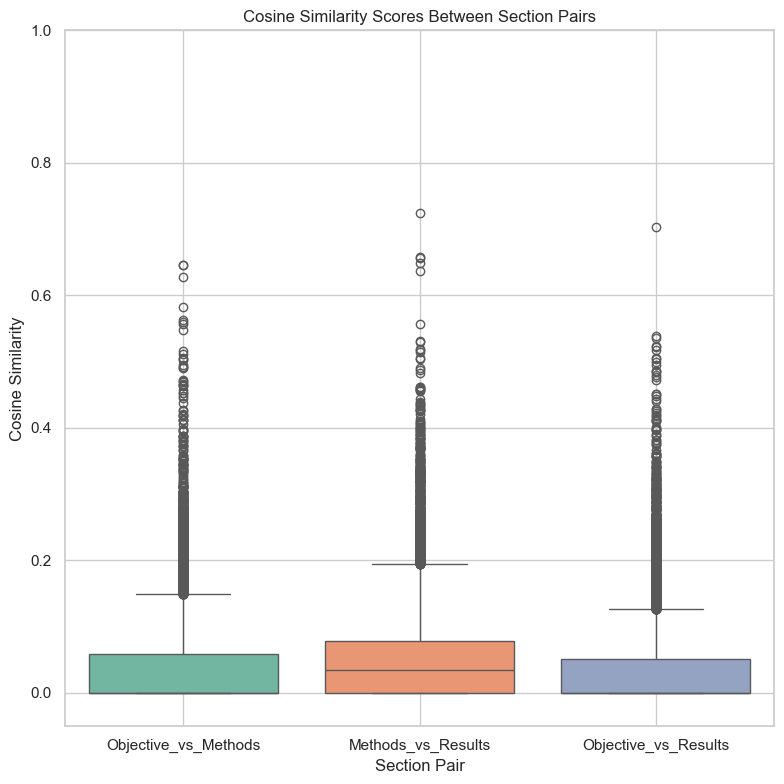

In [97]:
sections = ['OBJECTIVE_BACKGROUND', 'METHODS', 'RESULTS_CONCLUSIONS']

for sec in sections:
    df[sec] = df[sec].fillna('').astype(str)
vectorizer = TfidfVectorizer(max_features=500)
tfidf_objective = vectorizer.fit_transform(df['OBJECTIVE_BACKGROUND'])
tfidf_methods = vectorizer.fit_transform(df['METHODS'])
tfidf_results = vectorizer.fit_transform(df['RESULTS_CONCLUSIONS'])


def rowwise_cosine(mat1, mat2):
    return [cosine_similarity(mat1[i], mat2[i])[0][0] for i in range(mat1.shape[0])]

df['Objective_vs_Methods'] = rowwise_cosine(tfidf_objective, tfidf_methods)
df['Methods_vs_Results'] = rowwise_cosine(tfidf_methods, tfidf_results)
df['Objective_vs_Results'] = rowwise_cosine(tfidf_objective, tfidf_results)

sim_df = pd.melt(df[['Objective_vs_Methods', 'Methods_vs_Results', 'Objective_vs_Results']],var_name='Section Pair',value_name='Cosine Similarity')

plt.figure(figsize=(8,8))
sns.boxplot(data=sim_df, x='Section Pair', y='Cosine Similarity', palette='Set2')
plt.title('Cosine Similarity Scores Between Section Pairs')
plt.ylim(sim_df['Cosine Similarity'].min() - 0.05, 1)
plt.grid(True)
plt.tight_layout()
plt.show()
